## Do Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import pprint
from __future__ import division
from __future__ import print_function
from datetime import datetime
import matplotlib.pyplot as plt
import os
from fractions import Fraction 
import scipy.odr.odrpack as odrpack
import time
from bisect import bisect_left
import datetime as dt
import matplotlib.dates as mdates
import calendar
from sklearn import preprocessing

## Define functions for the import of data

In [2]:
# smir out data
def smoothDataFrame(data, steps):
    # make sure that there are no nans! This would brick the cumsum function!
    # This may happen naturally when the packet_loss is at 1, so no packets get through
    # for simplicity we will drop those lines    
    data_smired = data.copy(deep=True)
    if "packet_loss" in data_smired.axes[1]:
        data_smired = data_smired.dropna(axis=0, subset=["delay_avg"])
    for col in data_smired.axes[1]:
        # do NOT smir our "throughput_perfSonar"
        if col == "throughput_perfSonar":
            continue
        vals = data_smired[col].values
        valsSumed = np.cumsum(vals)
        for i in range(steps, len(data_smired)):
            summ = valsSumed[i] - valsSumed[i-steps]
            vals[i] = summ/steps
        vals[:steps] = float('nan')
        data_smired[col] = vals
    # make sure not to use the first values, which were not averaged, e.g. delete them
    data_smired = data_smired.drop(data_smired.index[:steps])
    return data_smired

## Import raw data and compute dataset

In [3]:
# read our raw data
data_router = pd.read_pickle("raw_data_routers/raw_router_CERN_to_RAL-PIC-TRIUMF-KIT-IN2P3-BNL-CNAF-JINR-T1_highres.pkl")
data_perfSonar = pd.read_pickle("raw_data_routers/raw_toolkit_CERN_to_RAL-PIC-TRIUMF-KIT-IN2P3-BNL-CNAF-JINR-T1_sorted.pkl")

In [4]:
# data processing
# smooth data
steps = 3
data_router = smoothDataFrame(data_router, steps)
steps = 15
for key1 in data_perfSonar.keys():
    for key2 in data_perfSonar[key1]:
        for key3 in data_perfSonar[key1][key2]:
            # smir the data
            data_perfSonar[key1][key2][key3] = smoothDataFrame(data_perfSonar[key1][key2][key3], steps)
            # add the gradient for delay_avg and packetloss
            data_perfSonar[key1][key2][key3]['delay_avg_gradient'] = np.gradient(data_perfSonar[key1][key2][key3]['delay_avg'], edge_order=2)
            data_perfSonar[key1][key2][key3]['packet_loss_gradient'] = np.gradient(data_perfSonar[key1][key2][key3]['packet_loss'], edge_order=2)
       
# make dates for the plots
dates_router = []
for stamp in data_router.index:
    dates_router.append(dt.datetime.fromtimestamp(stamp))
    
dates_perfSonar = {}
for src in data_perfSonar:
    dates_perfSonar[src] = {}
    for dest in data_perfSonar[src]:
        dates_perfSonar[src][dest] = {}
        for direction in data_perfSonar[src][dest]:
            dates_perfSonar[src][dest][direction] = []
            for stamp in data_perfSonar[src][dest][direction].index:
                dates_perfSonar[src][dest][direction].append(dt.datetime.fromtimestamp(stamp))
                

In [5]:
#test printing

counter = 0
for i in range(len(data_perfSonar['CERN']['RAL']['in']['throughput_perfSonar'])):
    if math.isnan(data_perfSonar['CERN']['RAL']['in']['throughput_perfSonar'].iloc[i]):
        continue
    counter += 1
print(counter)

for key1 in data_perfSonar.keys():
    print(key1 + " <-> ", end="")
    for key2 in data_perfSonar[key1].keys():
        print(key2 + " | ", end="")
    print(" ")

print(data_perfSonar['CERN']['KIT']['out'].axes[1])

99
CERN <-> CNAF | PIC | RAL | KIT | CCIN2P3 | JINR-T1 | TRIUMF | BNL |  
Index(['packet_loss', 'ttl_avg', 'ttl_std', 'ttl_median',
       'time_error_estimates', 'delay_avg', 'delay_std', 'delay_median',
       'throughput_perfSonar', 'delay_avg_gradient', 'packet_loss_gradient'],
      dtype='object')


## Do NN learning

In [6]:
def findIndexClosestToTimestamp_mod(timestamp, dataPoints, collumThatIsNotNAN):
    '''
    Returns a data point from dataPoints, that is closest to the given timestamp.
    As well the dataPoint will not be nan in the collum "collumThatIsNotNAN"
    Complexity of this command: O( log( len(dataPoints) ) )
    '''
    timestamps_toSearch = dataPoints.axes[0]
    cols = list(dataPoints.axes[1])
    data = dataPoints.values
    # bisect only works because we know our list is sorted
    pos = bisect_left(timestamps_toSearch, timestamp)
    if pos == len(dataPoints):
        pos = len(dataPoints)-1
    #print(pos)
    # find the closest datapoint, that is not a NAN and return it
    currentDataPoint = dict(zip(cols, dataPoints.values[pos]))
    if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
        return pos
    else:
        pos = findIndexClostestThatIsNotNAN(pos, dataPoints, cols.index(collumThatIsNotNAN))
        return pos

def makeNewDataSet_NN(data_from_routers, data_from_perfSonar, timeframe, num_of_last_measurements=10, cut_throughput=0.7, throughput_max=(20*1e9)):
    # bisect doesn't work if the data is not sortet this way...
    data_from_routers = data_from_routers.sort_index(ascending=True).copy(deep=True)
    data_from_perfSonar = data_from_perfSonar.sort_index(ascending=True).copy(deep=True)
    # cut routers data
    pos1 = bisect_left(data_from_routers.index, timeframe[0])
    if pos1 == len(data_from_routers):
        pos1 = len(data_from_routers)-1
    pos2 = bisect_left(data_from_routers.index, timeframe[1])
    if pos2 == len(data_from_routers):
        pos2 = len(data_from_routers)-1
    data_from_routers = data_from_routers.drop(data_from_routers.index[0:pos1])
    data_from_routers = data_from_routers.drop(data_from_routers.index[pos2:len(data_from_routers)-1])
    data = []
    delay_all_time_avg = data_from_perfSonar['delay_avg'].mean()
    delay_all_time_std = data_from_perfSonar['delay_avg'].std()
    delay_all_time_min = data_from_perfSonar['delay_avg'].min()
    loss_all_time_avg = data_from_perfSonar['packet_loss'].mean()
    loss_all_time_std = data_from_perfSonar['packet_loss'].std()
    for i in range(len(data_from_routers)):
        if math.isnan(data_from_routers.values[i]) or data_from_routers.values[i] == 0.0:
            continue
        currentTimestamp = data_from_routers.index[i]
        index_perfSonar = findIndexClosestToTimestamp_mod(currentTimestamp, data_from_perfSonar, 'delay_avg')
        zw = dict(data_from_perfSonar.iloc[index_perfSonar])
        # include all time data
        zw['delay_all_time_avg'] = delay_all_time_avg
        zw['delay_all_time_std'] = delay_all_time_std
        zw['delay_all_time_min'] = delay_all_time_min
        zw['loss_all_time_avg'] = loss_all_time_avg
        zw['loss_all_time_std'] = loss_all_time_std
        # add last measurements
        if index_perfSonar < num_of_last_measurements:
            continue
        sumdelay = 0
        sumdelay_square = 0
        sumloss = 0
        sumloss_square = 0
        for j in range(1, num_of_last_measurements+1):
            dataPoint = data_from_perfSonar.iloc[index_perfSonar-j]
            zw['delay_avg_past_'+str(j)] = dataPoint['delay_avg']
            sumdelay += dataPoint['delay_avg']
            sumdelay_square += dataPoint['delay_avg']*dataPoint['delay_avg']
            zw['packet_loss_past_'+str(j)] = dataPoint['packet_loss']
            sumloss += dataPoint['packet_loss']
            sumloss_square += dataPoint['packet_loss']*dataPoint['packet_loss']
        zw['delay_avg_past_avg'] = sumdelay/num_of_last_measurements
        zw['packet_loss_past_avg'] = sumloss/num_of_last_measurements
        zw['delay_avg_past_std'] = np.sqrt((sumdelay_square/num_of_last_measurements)-(sumdelay/num_of_last_measurements)**2)
        zw['packet_loss_past_std'] = np.sqrt((sumloss_square/num_of_last_measurements)-(sumloss/num_of_last_measurements)**2)
        if math.isnan(zw['packet_loss_past_std']):
            zw['packet_loss_past_std'] = 0
        if math.isnan(zw['delay_avg_past_std']):
            zw['delay_avg_past_std'] = 0
        # add timestamp and throughput
        zw['timestamp'] = currentTimestamp
        zw['throughput'] = data_from_routers.values[i]
        if zw['throughput'] <= cut_throughput*throughput_max:
            zw['throughput'] = 0
        # pop deprecated data
        zw.pop('ttl_median', None)
        zw.pop('ttl_avg', None)
        zw.pop('ttl_std', None)
        zw.pop('time_error_estimates', None)
        data.append(zw)
    data = pd.DataFrame.from_dict(data)
    return data

def normalizeDataSet(dataSet, scaler_feature_range=(0, 1), scaler=None):
    # make sure we don't change our original object (wo don't want that)
    # use the sktlearn.preprocessing procedures, they prommis to be quite flexible
    workDataSet = dataSet.copy(deep=True)
    # append zeroes so that we are actually normalized to zero
    #zeroesDataFrame = pd.DataFrame(np.zeros([1,len(workDataSet.axes[1])]), columns=workDataSet.axes[1])
    #workDataSet = workDataSet.append(zeroesDataFrame, ignore_index=True)
    # fill up our nans as the function dosen't run with nans 
    workDataSet = workDataSet.fillna(0)
    collums = []
    for collum in workDataSet.axes[1]:
        # what to skip:
        if collum == "timestamp" or collum == "throughput" or collum == "throughput_perfSonar":
            continue
        collums.append(collum)
    # if you want to keep the scaler, then split this into a fit and a transform call
    if scaler == None:
        scaler = preprocessing.MinMaxScaler(feature_range=scaler_feature_range).fit(workDataSet[collums].as_matrix())
    workDataSet[collums] = scaler.transform(workDataSet[collums].as_matrix())
    # remove zeroes again
    #workDataSet = workDataSet.drop(len(workDataSet)-1, axis=0)
    return workDataSet, scaler

def inverseNormalizeDataSet(dataSet, scaler):
    # make sure we don't change our original object (wo don't want that)
    # use the sktlearn.preprocessing procedures, they prommis to be quite flexible
    workDataSet = dataSet.copy(deep=True)
    collums = []
    for collum in workDataSet.axes[1]:
        # what to skip:
        if collum == "timestamp" or collum == "throughput":
            continue
        collums.append(collum)
    workDataSet[collums] = scaler.inverse_transform(workDataSet[collums].as_matrix())
    # remove zeroes again
    #workDataSet = workDataSet.drop(len(workDataSet)-1, axis=0)
    return workDataSet

def normalize_throughput(throughput_array, throughputMaxGBits):
    zw = throughput_array
    zw = throughput_array/(throughputMaxGBits*1e9)
    zw = (zw*0.8)+0.1
    return zw

def inverses_normalize_throughput(throughput_array, throughputMaxGBits):
    zw = throughput_array
    zw = (zw-0.1)/0.8
    zw = zw * (throughputMaxGBits*1e9)
    return zw

def make_all_data_sets_for_NN(timeframe_ext, num_of_last_measurements, cut_throughput, throughput_mapping):
    # set up stuff
    timeframe = [calendar.timegm(dt.datetime.strptime(t, '%d-%m-%Y %H:%M').timetuple()) for t in timeframe_ext]
    # get all directions
    data_set = pd.DataFrame()
    for src in data_perfSonar.keys():
        for dest in data_perfSonar[src].keys():
            # skip JINR-T1 it has super strange router data...
            # as well skip RAL, they have a baaaad router
            if dest == "JINR-T1" or dest == "RAL":
                continue
            #if dest == "JINR-T1":
            #    continue
            throughputMaxGBits = throughput_mapping[dest]
            # make dataset for direction: in
            direction = "out"
            print("Creating data_set: "+src+" and "+dest+" dir: "+direction)
            throughputs = []
            for router in data_router.axes[1]:
                if dest in router and direction in router[len(router)-3:]:
                    throughputs.append(data_router[router])
            data_from_routers = sum(throughputs).copy(deep=True)
            data_from_perfSonar = data_perfSonar[src][dest][direction].copy(deep=True)
            data_set_tmp = makeNewDataSet_NN(data_from_routers, data_from_perfSonar,
                             timeframe, num_of_last_measurements=num_of_last_measurements,
                            cut_throughput=cut_throughput, throughput_max=(throughputMaxGBits*1e9))
            # normalize throughput
            data_set_tmp['throughput'] = normalize_throughput(data_set_tmp['throughput'], throughputMaxGBits)
            # append data_set
            data_set = data_set.append(data_set_tmp, ignore_index=True)
            # make dataset for direction: out
            # basically do the same
            direction = "in"
            print("Creating data_set: "+src+" and "+dest+" dir: "+direction)
            throughputs = []
            for router in data_router.axes[1]:
                if dest in router and direction in router[len(router)-3:]:
                    throughputs.append(data_router[router])
            data_from_routers = sum(throughputs).copy(deep=True)
            data_from_perfSonar = data_perfSonar[src][dest][direction].copy(deep=True)
            data_set_tmp = makeNewDataSet_NN(data_from_routers, data_from_perfSonar,
                             timeframe, num_of_last_measurements=num_of_last_measurements,
                            cut_throughput=cut_throughput, throughput_max=(throughputMaxGBits*1e9))
            data_set_tmp['throughput'] = normalize_throughput(data_set_tmp['throughput'], throughputMaxGBits)
            data_set = data_set.append(data_set_tmp, ignore_index=True)
    return data_set


### Train NN

In [7]:
# make dataset
throughput_mapping = {"JINR-T1": 20, "RAL": 20, "TRIUMF": 10, "CNAF": 40, "KIT": 20,
                      "CCIN2P3": 20, "PIC": 10, "BNL": 50}
num_of_last_measurements = 15
cut_throughput = 0.7
timeframe_readable_train = ['11-09-2016 16:00', '28-09-2016 16:00']

data_set_all = make_all_data_sets_for_NN(timeframe_readable_train, num_of_last_measurements, cut_throughput, throughput_mapping)

Creating data_set: CERN and CNAF dir: out
Creating data_set: CERN and CNAF dir: in
Creating data_set: CERN and PIC dir: out
Creating data_set: CERN and PIC dir: in
Creating data_set: CERN and KIT dir: out
Creating data_set: CERN and KIT dir: in
Creating data_set: CERN and CCIN2P3 dir: out
Creating data_set: CERN and CCIN2P3 dir: in
Creating data_set: CERN and TRIUMF dir: out
Creating data_set: CERN and TRIUMF dir: in
Creating data_set: CERN and BNL dir: out
Creating data_set: CERN and BNL dir: in


In [8]:
#%%capture
# we don't want to see the output, as it badly slows the browser

# normalize dataset
data_set_normalized, scaler_for_dataSet_all = normalizeDataSet(data_set_all)
data_set_normalized_NN_Input = data_set_normalized.drop(['throughput','timestamp','throughput_perfSonar'], axis=1)
data_set_normalized_NN_Output = data_set_normalized['throughput']

# train NN
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

activation_func = 'relu'
layer_init = ""
# standard:
#b_size = 32
b_size = 512
validation_split = 0.0
training_epochs = 50
dropout_ratio = 0.5

model = Sequential()
model.add(Dense(100, input_dim=len(data_set_normalized_NN_Input.axes[1]), activation=activation_func, init='uniform'))
model.add(Dropout(dropout_ratio))
model.add(Dense(50, activation=activation_func))
model.add(Dropout(dropout_ratio))
model.add(Dense(5, activation=activation_func))
# last/output layer
model.add(Dense(1, activation=activation_func))

model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(data_set_normalized_NN_Input.as_matrix(), data_set_normalized_NN_Output.as_matrix(),
                    nb_epoch=training_epochs, batch_size=b_size, shuffle=True, validation_split=validation_split)

Using Theano backend.


Epoch 1/50
51256/51256 [==============================] - 0s - loss: 0.0202     
Epoch 2/50
51256/51256 [==============================] - 0s - loss: 0.0149     
Epoch 3/50
51256/51256 [==============================] - 0s - loss: 0.0128     
Epoch 4/50
51256/51256 [==============================] - 0s - loss: 0.0119     
Epoch 5/50
51256/51256 [==============================] - 0s - loss: 0.0108     
Epoch 6/50
51256/51256 [==============================] - 0s - loss: 0.0102     
Epoch 7/50
51256/51256 [==============================] - 0s - loss: 0.0098     
Epoch 8/50
51256/51256 [==============================] - 0s - loss: 0.0096     
Epoch 9/50
51256/51256 [==============================] - 0s - loss: 0.0092     
Epoch 10/50
51256/51256 [==============================] - 0s - loss: 0.0091     
Epoch 11/50
51256/51256 [==============================] - 0s - loss: 0.0090     
Epoch 12/50
51256/51256 [==============================] - 0s - loss: 0.0088     
Epoch 13/50
51256/51256 [

In [1733]:
import pickle
# save model
model.save('global_NN_for_netTel.h5')  # creates a HDF5 file 'global_NN_model_1.h5'
# save our scaler
pickle.dump(scaler_for_dataSet_all, open( "global_NN_for_netTel_scaler.pkl", "wb" ),
            protocol=2 )

### Validate on other timeframe

In [1913]:
# create valida
throughput_mapping = {"JINR-T1": 20, "RAL": 20, "TRIUMF": 10, "CNAF": 40, "KIT": 20,
                      "CCIN2P3": 20, "PIC": 10, "BNL": 50}
num_of_last_measurements = 15
cut_throughput = 0.7
timeframe_readable = ['28-09-2016 16:00', '02-10-2016 16:00']

data_set2 = make_all_data_sets_for_NN(timeframe_readable, num_of_last_measurements, cut_throughput, throughput_mapping)

Creating data_set: CERN and TRIUMF dir: out
Creating data_set: CERN and TRIUMF dir: in
Creating data_set: CERN and CNAF dir: out
Creating data_set: CERN and CNAF dir: in
Creating data_set: CERN and KIT dir: out
Creating data_set: CERN and KIT dir: in
Creating data_set: CERN and CCIN2P3 dir: out
Creating data_set: CERN and CCIN2P3 dir: in
Creating data_set: CERN and PIC dir: out
Creating data_set: CERN and PIC dir: in
Creating data_set: CERN and BNL dir: out
Creating data_set: CERN and BNL dir: in


21140/21140 [==============================] - 0s     


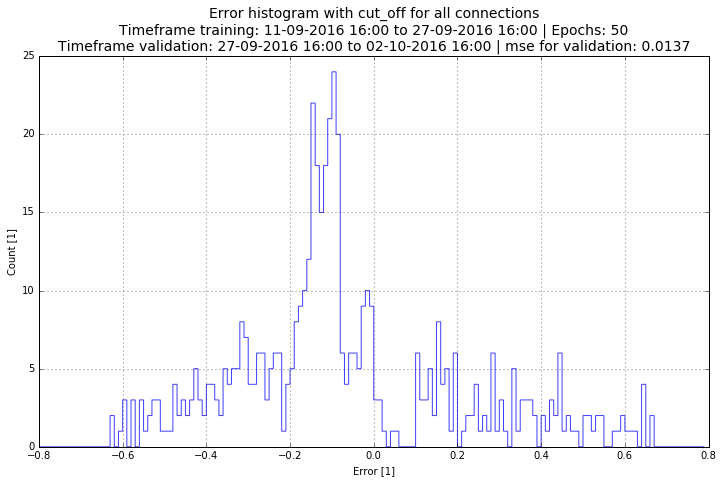

In [1906]:
data_set_normalized, useless_scaler = normalizeDataSet(data_set2, scaler=scaler_for_dataSet_all)
data_set_normalized_NN_Input = data_set_normalized.drop(['throughput','timestamp','throughput_perfSonar'], axis=1)
data_set_normalized_NN_Output = data_set_normalized['throughput']

score = model.evaluate(data_set_normalized_NN_Input.as_matrix(), data_set_normalized_NN_Output.as_matrix(),
                       batch_size=b_size)
prediction = model.predict(data_set_normalized_NN_Input.as_matrix(), batch_size=b_size)

# make error histogram
bins = np.arange(-0.8, 0.8, 0.01)
#bins = 300
cut_offset = 0.1
#cut_offset = 0.06
savePath = ''
savePath = 'plots/a_presentation_plots/'

title = "Error histogram with cut_off for all connections"
title += "\nTimeframe training: "+str(timeframe_readable_train[0])+" to "+str(timeframe_readable_train[1]) + " | Epochs: "+ str(training_epochs) 
#title += "\n activation func: " + activation_func
title += "\nTimeframe validation: "+str(timeframe_readable[0])+" to "+str(timeframe_readable[1])
title += " | "+ str(model.loss) +" for validation: " + str(round(score, 4))

rs_prediction = np.reshape(prediction, (len(prediction),))
diff = rs_prediction - data_set_normalized_NN_Output.as_matrix()
diff = diff
# cut median, its falsely called minimum here
minimum = np.median(rs_prediction)
validPoints = []
for i in range(len(diff)):
    if rs_prediction[i] >= (minimum+cut_offset):
        validPoints.append(diff[i])
fig, ax1 = plt.subplots()
fig.set_size_inches(12,7)
fig.set_dpi(300)
n, bins, patches = plt.hist(validPoints, bins, normed=False, histtype='step', facecolor='green',
                            alpha=0.75, orientation='vertical')

plt.xlabel("Error [1]")
plt.ylabel('Count [1]')
plt.title(title, fontsize=14)
plt.grid(True)

if savePath != '' :
    fname = title
    plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

### Validate on one specific connection

In [1796]:
# create data Set
# configuration
src = "CERN"
dest = "RAL"
direction = "out"
num_of_last_measurements = 15
throughputMaxGBits = 20
throughputPercentage = 0.7
#timeframe_readable = ['11-09-2016 16:00', '27-09-2016 16:00']
timeframe_readable = ['27-09-2016 16:00', '02-10-2016 16:00']
#scaler = None
scaler = scaler_for_dataSet_all

# setting stuff up
timeframe = [calendar.timegm(dt.datetime.strptime(t, '%d-%m-%Y %H:%M').timetuple()) for t in timeframe_readable]

# make dataSet
print("Creating data_set: "+src+" and "+dest+" | dir: "+direction)
throughputs = []
for router in data_router.axes[1]:
    if dest in router and direction in router[len(router)-3:]:
        throughputs.append(data_router[router])
data_from_routers = sum(throughputs).copy(deep=True)
data_from_perfSonar = data_perfSonar[src][dest][direction].copy(deep=True)

data_set1 = makeNewDataSet_NN(data_from_routers, data_from_perfSonar,
                             timeframe, num_of_last_measurements=num_of_last_measurements,
                            cut_throughput=cut_throughput, throughput_max=(throughputMaxGBits*1e9))

print("data_set size: "+ str(len(data_set1)))
print("vars per data point: "+ str(len(data_set1.axes[1])))

#data_set_normalized, scaler_for_dataSet = normalizeDataSet(data_set1, scaler_feature_range=(0.1, 0.9), scaler=scaler)
data_set_normalized, scaler_for_dataSet = normalizeDataSet(data_set1, scaler=scaler)
# normalize throughput manualy as we have intel about it ^^
# bring it to a region between 0.05 and 0.95
data_set_normalized['throughput'] = normalize_throughput(data_set_normalized['throughput'], throughputMaxGBits)

data_set_normalized_NN_Input = data_set_normalized.drop(['throughput','timestamp','throughput_perfSonar'], axis=1)
data_set_normalized_NN_Output = data_set_normalized['throughput']

Creating data_set: CERN and RAL | dir: out
data_set size: 1510
vars per data point: 48


1248/1510 [=======================>......] - ETA: 0s

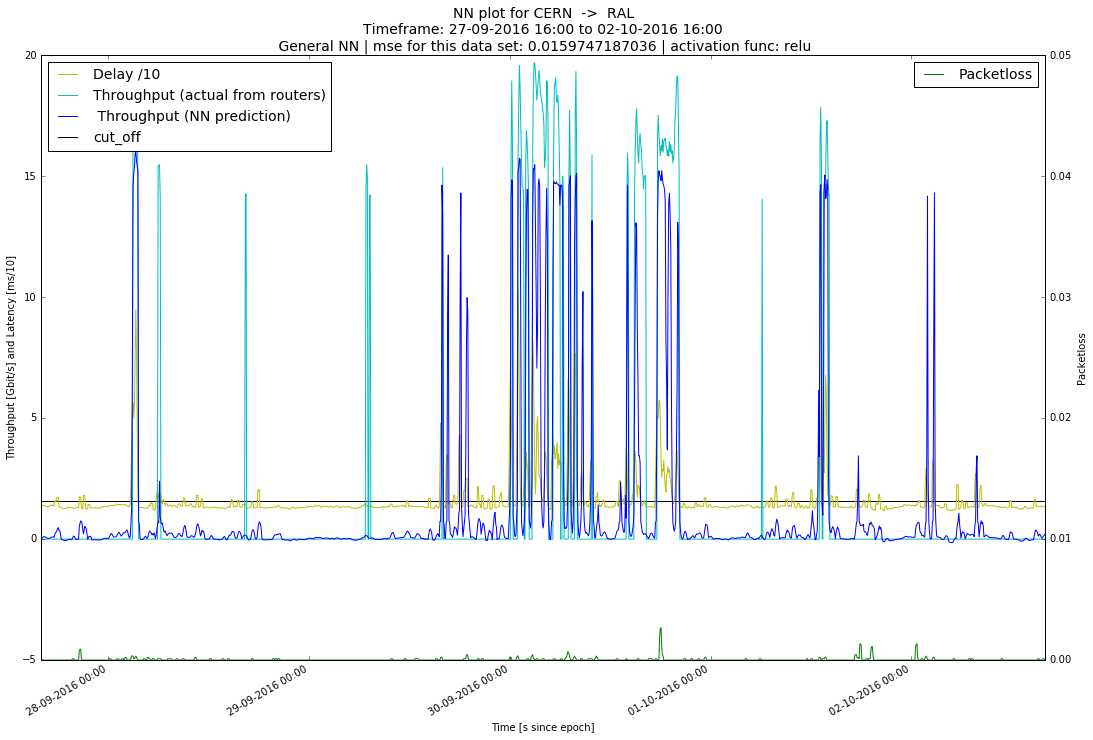

In [1797]:
score = model.evaluate(data_set_normalized_NN_Input.as_matrix(), data_set_normalized_NN_Output.as_matrix(),
                       batch_size=b_size)
prediction = model.predict(data_set_normalized_NN_Input.as_matrix(), batch_size=b_size)

timeframe_readable_new = timeframe_readable
#timeframe_readable_new = ['14-09-2016 06:00', '16-09-2016 00:00']
savePath = ''
#savePath = 'plots/router_multi_plots_2016-09-29/'
title_suffix = "\n General NN | "+ str(model.loss) +" for this data set: " + str(score) + " | activation func: " + activation_func

title_NN_plot = makePlot_forNN(src, dest, direction, timeframe_readable_new,
               data_set1, inverses_normalize_throughput(prediction, throughputMaxGBits), title_suffix=title_suffix, savePath=savePath)

median is: 0.104286


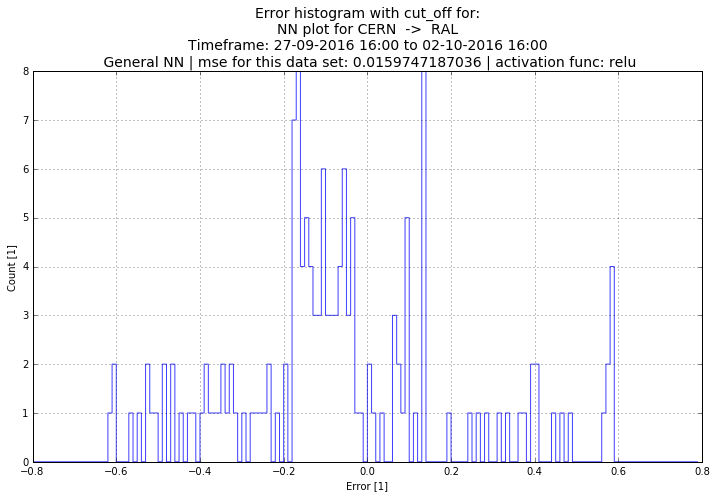

In [1798]:
# make error histogram
bins = np.arange(-0.8, 0.8, 0.01)
cut_offset = 0.06
savePath = ''
#savePath = 'plots/router_multi_plots_2016-09-29/'
title = "Error histogram with cut_off for:\n" + title_NN_plot

rs_prediction = np.reshape(prediction, (len(prediction),))
diff = rs_prediction - data_set_normalized_NN_Output.as_matrix()
diff = diff
# cut minimum
minimum = np.median(rs_prediction)
print("median is: "+str(minimum))
validPoints = []
for i in range(len(diff)):
    if rs_prediction[i] >= (minimum+cut_offset):
        validPoints.append(diff[i])
fig, ax1 = plt.subplots()
fig.set_size_inches(12,7)
fig.set_dpi(300)
n, bins, patches = plt.hist(validPoints, bins, normed=False, histtype='step', facecolor='green',
                            alpha=0.75, orientation='vertical')

plt.xlabel("Error [1]")
plt.ylabel('Count [1]')
plt.title(title, fontsize=14)
plt.grid(True)

if savePath != '' :
    fname = title
    plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

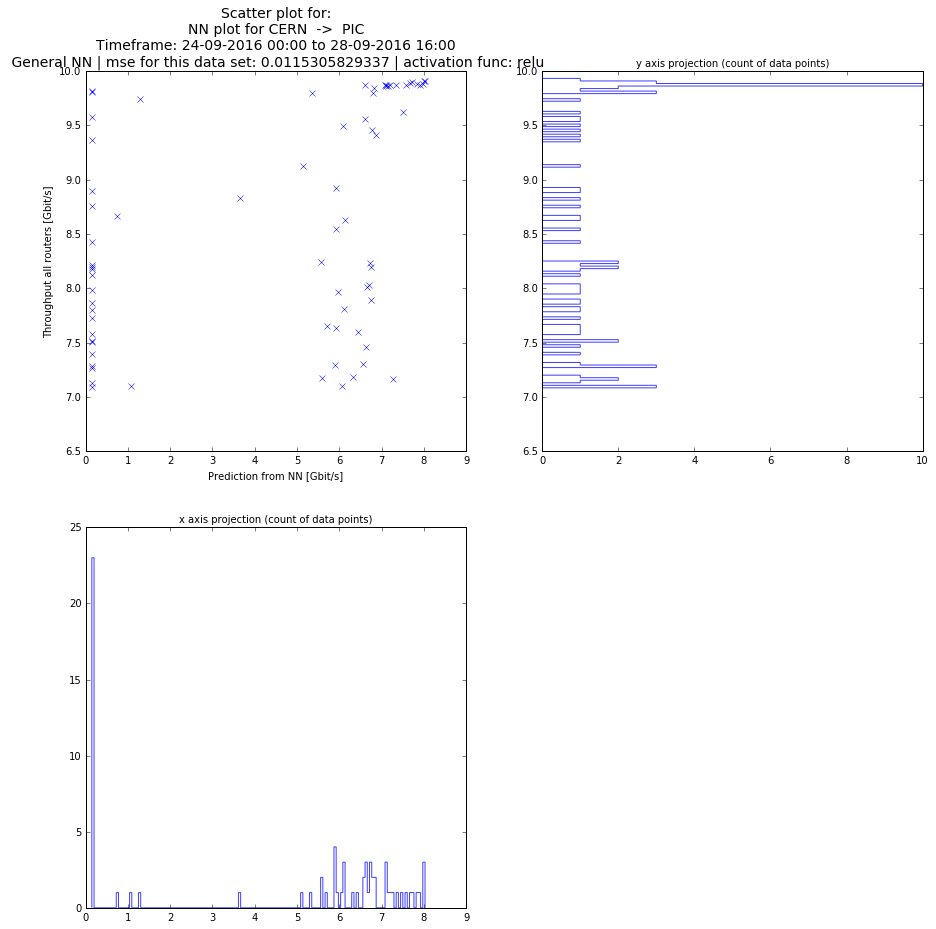

In [1581]:
# scatter plot, yeah!
num_bins1 = 150
num_bins2 = 150
normed = False
ylim = (throughputMaxGBits*0.65, throughputMaxGBits)
title = "Scatter plot for:\n" + title_NN_plot
fname = title

rs_prediction = np.reshape(prediction, (len(prediction),))
predictionGBits = inverses_normalize_throughput(rs_prediction, throughputMaxGBits)/1e9
actualValsGBits = inverses_normalize_throughput(data_set_normalized_NN_Output.as_matrix(), throughputMaxGBits)/1e9
pointsForXprojection = []
for i in range(len(actualValsGBits)):
    if actualValsGBits[i] >= ylim[0]:
        pointsForXprojection.append(predictionGBits[i])

# plot the data we got
fig, ax1 = plt.subplots()
fig.set_size_inches(15,15)
fig.set_dpi(300)

plt.subplot(221)
# scaterplot itself
plt.title(title,fontsize=14)
plt.plot(predictionGBits, actualValsGBits, 'bx', label="")
plt.ylabel("Throughput all routers [Gbit/s]")
plt.xlabel("Prediction from NN [Gbit/s]")

#plt.legend(loc='best',fontsize=8)
current_xlim = (plt.xlim())
plt.ylim(ylim)

# histogram y axis
plt.subplot(222)
bin1 = np.arange(ylim[0], ylim[1], abs(ylim[0]-ylim[1])/num_bins1)
plt.title("y axis projection (count of data points)",fontsize=10)
n, bins, patches = plt.hist(actualValsGBits, bin1, normed=normed, histtype='step', facecolor='green',
                                alpha=0.75, orientation='horizontal')

# histogram x axis
plt.subplot(223)
plt.title("x axis projection (count of data points)",fontsize=10)
#bin2 = np.arange(xlim[0], xlim[1], abs(xlim[0]-xlim[1])/num_bins2)
n, bins, patches = plt.hist(pointsForXprojection, num_bins2, normed=normed, histtype='step', facecolor='green',
                                alpha=0.75, orientation='vertical')
plt.xlim(current_xlim)
#plt.ylim(0, 100)


#plt.savefig('plots/router_multi_plots_2016-09-29/'+ fname +'.png', format='PNG', dpi=300)

plt.show()

In [1310]:
def makePlot_forNN(src, dest, direction, timeframe, data_set_local, prediction_bw, title_suffix='', savePath=''):
    # set stuff up
    direction_counter = "in"
    if direction == "in":
        direction_counter = "out"
    dirMarker = " <- "
    if direction == "out":
        dirMarker = " -> "
    title = "NN plot for "+src+" "+dirMarker+" "+dest +"\nTimeframe: "+str(timeframe[0])+" to "+str(timeframe[1])+title_suffix
    fname = title
    # make dates
    dates_data_set = []
    for stamp in data_set_local['timestamp']:
        dates_data_set.append(dt.datetime.fromtimestamp(stamp))
    # plot the data we got
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18,12)
    fig.set_dpi(300)
    plt.title(title,fontsize=14)

    # make first axis
    ax1.hlines(inverses_normalize_throughput((minimum+cut_offset), throughputMaxGBits)/1e9, [0], [999999999999999999], label="cut_off")
    ax1.plot(dates_data_set, data_set_local["delay_avg"]/10,
             'y', label=r'Delay /10')
    # get throughput
    ax1.plot(dates_data_set, data_set_local['throughput']/1e9,
             'c', label=r'Throughput (actual from routers)')
    ax1.plot(dates_data_set, prediction_bw/1e9,
             'b', label=r' Throughput (NN prediction)')
    
    # make second axis
    ax2 = ax1.twinx()
    ax2.plot(dates_data_set, data_set_local["packet_loss"],
             'g', label=r'Packetloss')

    # limits
    #ax1.set_ylim([0, 20])
    ax2.set_ylim([0, 0.05])
    plt.xlim([dt.datetime.strptime(t, '%d-%m-%Y %H:%M') for t in timeframe])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
    plt.gcf().autofmt_xdate()
    # legends and lables
    ax1.set_ylabel("Throughput [Gbit/s] and Latency [ms/10]")
    ax1.set_xlabel("Time [s since epoch]")
    ax1.legend(loc='upper left',fontsize=14)
    ax2.set_ylabel("Packetloss")
    ax2.legend(loc='upper right',fontsize=14)
    # saving?
    if savePath != '' :
        plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
    plt.show()
    return title

In [1573]:
len(data_set_normalized_NN_Input.axes[1])

45

In [690]:
print(score)

0.0196422660113
